# SVM solution of MNIST proble

## 1. Load data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')
args.n_splits = 5

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [2]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


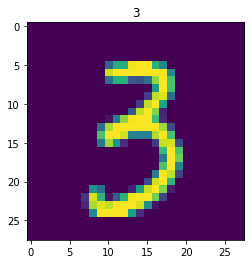

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
plt.title(title)
imgplot = plt.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

## 2. Training

In [6]:
args.X = args.raw_train.iloc[:, 1:].copy()
args.y = args.raw_train['label'].copy()
args.x = args.raw_test.copy()

In [41]:
def predict(X, y, x, build_classifier, parameters, splits=args.n_splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    classifier = build_classifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=3)
    gcv.fit(X, y)
    print('Best params: ' + repr(gcv.best_params_))
    print('Best CV score: ' + repr(gcv.best_score_))
    print('Best std:' + repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    classifier = build_classifier(gcv.best_params_)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

In [26]:
def csv_predictions(predictions, filename):
    image_ids = np.arange(1, len(predictions) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    print('Saved file: ', filepath)

### 2.1 SVM

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def predict_svm(X, y, x, splits=args.n_splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    parameters = {'C': [0.01, 0.1], 'gamma': [0.001]}
    classifier = SVC(kernel='linear')
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=3)
    gcv.fit(X, y)
    print('SVM best params: ' + repr(gcv.best_params_))
    print('SVM best CV score: ' + repr(gcv.best_score_))
    classifier = SVC(**gcv.best_params_, kernel='linear')
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

### 2.2 Random Forest

In [44]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def random_forest_classifier_builder(params_dict=None):
    if not params_dict 
    return RandomForestClassifier(**params_dict, n_jobs=-1, oob_score=False)

# parameters = {'n_estimators': [600], 'max_features': [40], 
#               'min_samples_leaf': [1], 'max_depth': [30, 40]}
parameters = {'n_estimators': [1], 'max_features': [1], 
              'min_samples_leaf': [1], 'max_depth': [1, 2]}

best_params, score, predictions = predict(args.X, args.y, args.x, random_forest_classifier_builder, parameters)
csv_predictions(predictions, 'random_forest1.csv')

TypeError: ABCMeta object argument after ** must be a mapping, not NoneType

In [7]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def predict_random_forest(X, y, x, splits=args.n_splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    parameters = {'n_estimators': [600], 'max_features': [40], 
                  'min_samples_leaf': [1], 'max_depth': [30, 40]}
    rfc = RandomForestClassifier(n_jobs=-1, oob_score=False)
    gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=5)
    gcv.fit(X, y)
    print('RandomForest best params: ' + repr(gcv.best_params_))
    print('RandomForest best CV score: ' + repr(gcv.best_score_))
    classifier = RandomForestClassifier(**gcv.best_params_, n_jobs=-1, oob_score=False)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

In [8]:
best_params, score, predictions = predict_random_forest(args.X, args.y, args.x)
csv_predictions(predictions, 'random_forest.csv')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed: 25.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 25.6min finished


RandomForest best params: {'max_depth': 40, 'max_features': 40, 'min_samples_leaf': 1, 'n_estimators': 600}
RandomForest best CV score: 0.9669761904761905


## 3. Model Evaluation

| Model  | Test score  |
|---|---|
| Random Forest  | 0.96685 |